# Facial Landmarks Detection

**References**

[1] http://www.ifp.illinois.edu/~vuongle2/helen/

[2] https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

[3] http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf

## Setup

Before running this notebook user should run the following two scripts:

1. `merge_annotations.py` (script merges all train and test annotations in a single file)
2. `crop_faces.py` (script crops the annoted face and masks out the rest of the image).
3. `rescale_images.py` (script takes original images and landmarks and rescales them to a fixed size)

We do this such that accessing data is both faster and requires less work.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, utils
from tqdm import tqdm

In [3]:
landmarks_frame = pd.read_csv('./resized_data/annotations/annotations_train.csv', index_col=0)
landmarks_frame.head()

,image_name,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_189,y_189,x_190,y_190,x_191,y_191,x_192,y_192,x_193,y_193
0,1279298224_1.jpg,2.225441,168.946588,6.989924,177.023739,11.274559,185.872404,14.323678,195.626113,17.784635,...,131.232997,88.032641,143.879093,87.652819,156.290932,88.388724,168.525189,89.433234,181.031486,88.988131
1,183204955_1.jpg,5.089286,158.004073,7.705357,166.588595,10.785714,176.242363,15.767857,185.199593,20.839286,...,56.446429,103.142566,66.071429,102.531568,76.017857,102.684318,85.419643,103.600815,95.035714,104.211813
2,2652716534_1.jpg,4.550649,153.680982,6.475325,163.349693,7.044156,173.472393,7.854545,183.447853,9.833766,...,115.597403,86.208589,126.148052,89.588957,135.716883,95.134969,145.363636,100.588957,156.522078,102.926380
3,2936372160_1.jpg,3.474684,146.900682,3.455696,156.654333,2.870886,167.266796,2.145570,177.078870,2.008861,...,100.739241,91.101266,112.093671,92.789679,123.136709,94.971762,133.682278,97.895813,144.744304,100.092502
4,167671301_1.jpg,3.136364,131.490196,4.446640,141.250980,5.567194,151.047059,6.729249,160.823529,8.193676,...,98.745059,80.827451,112.873518,82.694118,126.462451,85.250980,139.328063,88.968627,152.389328,92.309804


In [10]:
m, n = landmarks_frame.shape
rand_idx = np.random.randint(0, m - 1)

image_name = landmarks_frame.iloc[rand_idx, 0]
image = io.imread(f"./resized_data/train/{image_name}")
landmarks = landmarks_frame.iloc[rand_idx, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(image_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 10405424_1.jpg
Landmarks shape: (194, 2)
First 4 Landmarks: [[  2.41641337 152.73837209]
 [  4.13069909 161.6372093 ]
 [  6.2781155  170.53604651]
 [  8.0881459  180.22674419]]


In [11]:
def show_landmarks(image, landmarks):
    if isinstance(image, torch.Tensor):
        image = image.numpy()
        image = image.transpose((1, 2, 0))

    if isinstance(landmarks, torch.Tensor):
        landmarks = landmarks.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.scatter(x=landmarks[:, 0], y=landmarks[:, 1], s=20, marker=".")
    plt.show()

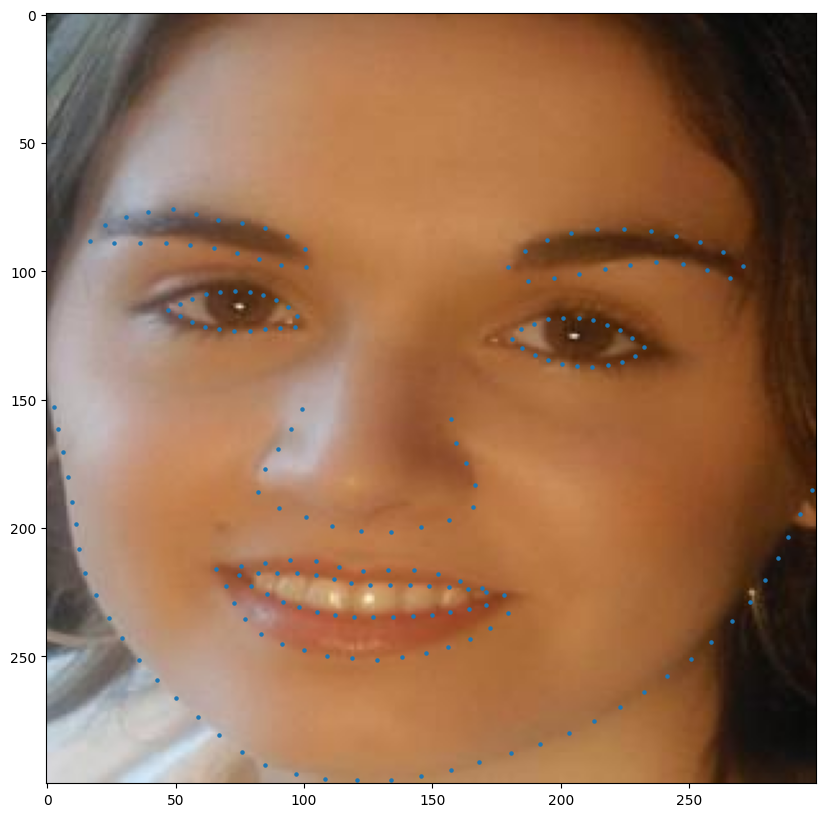

In [12]:
show_landmarks(image, landmarks)

## Implement a custom data class

In [13]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None) -> None:
        super().__init__()

        self.landmarks_frame = pd.read_csv(csv_file, index_col=0)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(image_name)
        landmarks = np.array(self.landmarks_frame.iloc[idx, 1:])
        landmarks = landmarks.astype("float").reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
class Rescale(object):
    def __init__(self, output_size):
        self.output_size = output_size


    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        h, w = image.shape[:2]

        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image,(new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]

        sample = {"image": image, "landmarks": landmarks}
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

class Normalize(object):
    def __init__(self, mean, std):
        if not isinstance(mean, torch.Tensor):
            mean = torch.tensor(mean)

        if not isinstance(std, torch.Tensor):
            std = torch.tensor(std)

        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, annotation = sample

        # Subtract the mean and divide by the std
        mean = self.mean.reshape((3, 1, 1))
        std = self.std.reshape((3, 1, 1))
        image = (image - mean) / std

        return image, annotation
        
class DropDictionary(object):
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        return image, landmarks

In [15]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
])

data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                root_dir="./resized_data/train/",
                                transform=composed_transform)

In [16]:
num_train = int(0.8 * len(data_set))

train_loader = DataLoader(Subset(data_set, range(num_train)),
                        batch_size=64,
                        shuffle=True,
                        num_workers=0)


val_loader = DataLoader(Subset(data_set, range(num_train, len(data_set))),
                        batch_size=64,
                        shuffle=True,
                        num_workers=0)

In [17]:
import time
start_time = time.time()

for batch_idx, sample_batched in enumerate(train_loader):
    image, landmarks = sample_batched
    print(batch_idx, image.size(), landmarks.size())
    
    break

print("--- %s seconds ---" % (time.time() - start_time))

0 torch.Size([64, 3, 256, 256]) torch.Size([64, 194, 2])
--- 0.7913417816162109 seconds ---


## Load pretrained ResNet model

In [18]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

#from torchvision.models import resnet18, ResNet18_Weights
#model = resnet18(pretrained=True)

## Implement architecture

We'll implemenet the following architecture.

![Architecture](img/achitecture.png)

**Swap final fully connected layer**

In [19]:
IN_FEATURES = model.fc.in_features
NUM_LANDMARKS = 194 * 2
model.fc = nn.Linear(in_features=IN_FEATURES, out_features=NUM_LANDMARKS)
print(model.fc)

Linear(in_features=512, out_features=388, bias=True)


In [20]:
sample_batched = next(iter(train_loader))
image, landmarks = sample_batched

image, landmarks = image[0], landmarks[0]
image = image.unsqueeze(dim=0)

# Change dtype to double, since model weights are double
image = image.to(torch.double)
landmarks = landmarks.to(torch.double)
model = model.double()

out = model(image)
out.shape

torch.Size([1, 388])

### Hyper-parameter optimization

Find a decent value for learning rate and weight decay, by training the model
for 10 epochs.

In [21]:
BATCH_SIZE = 64

num_train = int(0.8 * len(data_set))
train_loader = DataLoader(Subset(data_set, range(num_train)),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

val_loader = DataLoader(Subset(data_set, range(num_train, len(data_set))),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

x_train_batch, y_train_batch = next(iter(train_loader))
x_val_batch, y_val_batch = next(iter(val_loader))

x_train_batch.shape, x_val_batch.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 3, 256, 256]))

In [ ]:
# Optimize in log space
NUM_EPOCHS = 10
NUM_RUNS = 25

min_val_loss = None
best_lr, best_wd = None, None


for test_idx in range(NUM_RUNS):
    # Reinit the model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=IN_FEATURES, out_features=NUM_LANDMARKS)

    # Generate hyper-params in log space (from uniform distribution)
    wd = (10 ** (torch.rand(1) * 5 - 5)).item()
    lr = (10 ** (torch.rand(1) * 1 - 2.5)).item()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    start_time = time.time()

    for epoch in range(NUM_EPOCHS):

        # Iterate over training batches
        for batch_idx, train_batch in enumerate(train_loader):
            x_train_batch, y_train_batch = train_batch

            # Train on 3 batches of data, otherwise the hyper-param
            # search would take waaaay to long.
            if batch_idx == 3:
                break

            # Move tensors and model on cuda if available
            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                x_train_batch = x_train_batch.to(device)
                y_train_batch = y_train_batch.to(device)

            model = model.double()

            # Forward pass
            y_train_hat = model(x_train_batch)
            y_train_hat = y_train_hat.reshape((BATCH_SIZE, -1, 2))

            # Compute loss
            loss = torch.nn.functional.mse_loss(y_train_hat, y_train_batch)
        
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    
    train_time = time.time() - start_time

    # Compute loss on validation set
    y_val_hat = model(x_val_batch)
    with torch.no_grad():
        y_val_hat = y_val_hat.reshape((BATCH_SIZE, -1, 2)) 
        val_loss = torch.nn.functional.mse_loss(y_val_hat, y_val_batch)

        if not min_val_loss or val_loss.item() < min_val_loss:
            min_val_loss = val_loss.item()
            best_lr, best_wd = lr, wd

    print(f"test_idx: {test_idx} \t train_time: {train_time} lr: {lr:.6f} \t wd: {wd:.6f} \t train_loss: {loss:.4f} \t val_loss: {val_loss:.4f}")

print(f"best_lr: {best_lr:.6f} \t best_wd: {best_wd:.6f} \t min_val_loss: {min_val_loss:.6f}")

In [ ]:
from itertools import product
from random import choice

NUM_EPOCHS = 10
NUM_RUNS =  15


min_val_loss = None
best_lr, best_wd = None, None

# Try 15 random combinations from the following set of lrs and wds.
lrs = [0.01, 0.0125, 0.015, 0.02, 0.025, 0.030]
wds = [0.000010, 0.000015, 0.000020, 0.000025, 0.000030, 0.000035]

for test_idx in range(NUM_RUNS):
    lr, wd = list(map(choice, (lrs, wds)))

    # Reinit the model and optimizer
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=IN_FEATURES, out_features=NUM_LANDMARKS)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    start_time = time.time()

    for epoch in range(NUM_EPOCHS):

        # Iterate over training batches
        for batch_idx, train_batch in enumerate(train_loader):
            x_train_batch, y_train_batch = train_batch

            # Train on 3 batches of data, otherwise the hyper-param
            # search would take waaaay to long.
            if batch_idx == 3:
                break

            # Move tensors and model on cuda if available
            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                x_train_batch = x_train_batch.to(device)
                y_train_batch = y_train_batch.to(device)

            model = model.double()

            # Forward pass
            y_train_hat = model(x_train_batch)
            y_train_hat = y_train_hat.reshape((BATCH_SIZE, -1, 2))

            # Compute loss
            loss = torch.nn.functional.mse_loss(y_train_hat, y_train_batch)
        
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    
    train_time = time.time() - start_time

    # Compute loss on validation set
    y_val_hat = model(x_val_batch)
    with torch.no_grad():
        y_val_hat = y_val_hat.reshape((BATCH_SIZE, -1, 2)) 
        val_loss = torch.nn.functional.mse_loss(y_val_hat, y_val_batch)

        if not min_val_loss or val_loss.item() < min_val_loss:
            min_val_loss = val_loss.item()
            best_lr, best_wd = lr, wd

    print(f"test_idx: {test_idx} \t train_time: {train_time} lr: {lr:.6f} \t wd: {wd:.6f} \t train_loss: {loss:.4f} \t val_loss: {val_loss:.4f}")

print(f"best_lr: {best_lr:.6f} \t best_wd: {best_wd:.6f} \t min_val_loss: {min_val_loss:.6f}")

In [ ]:
BEST_LR = 0.011342
BEST_WD = 0.000019

## Overfit a single batch of data

To make sure that the model and data is setup correctly and gain so confidence that we can learn the mapping from image to landmarks we'll overfit a single batch of 32 samples.

In [ ]:
BATCH_SIZE = 32

num_train = int(0.8 * len(data_set))
train_loader = DataLoader(Subset(data_set, range(num_train)),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

val_loader = DataLoader(Subset(data_set, range(num_train, len(data_set))),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

x_train_batch, y_train_batch = next(iter(train_loader))
x_val_batch, y_val_batch = next(iter(val_loader))

x_train_batch.shape, x_val_batch.shape

In [ ]:
NUM_EPOCHS = 200

optimizer = optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=0)
losses, epochs = [], []

for epoch in range(NUM_EPOCHS):
    model = model.double()

    # Move tensors and model on cuda if available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model = model.to(device)
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

    # Forward pass
    y_train_hat = model(x_train_batch)
    y_train_hat = y_train_hat.reshape((BATCH_SIZE, -1, 2))

    # Compute loss
    loss = torch.nn.functional.mse_loss(y_train_hat, y_train_batch)
   
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        losses.append(loss.item())
        epochs.append(epoch)
        print(f'\r Epoch: {epoch} Loss: {loss:.4f}', end='', flush=True)

In [ ]:
def plot_prediction(x, y, y_hat, n_samples=3, clip=False):
    # Move tensors to cpu and detach grad.
    x = x.to("cpu")
    y = y.to("cpu")
    y_hat = y_hat.to("cpu")
    x = x.detach()
    y = y.detach()
    y_hat = y_hat.detach()

    # Iterate over samples in the batch
    for x_i, y_i, y_hat_i in zip(x[:n_samples], y[:n_samples], y_hat[:n_samples]):
        if isinstance(x_i, torch.Tensor):
            x_i = x_i.numpy()
            x_i = x_i.transpose((1, 2, 0))
        
        if isinstance(y_i, torch.Tensor):
            y_i = y_i.numpy()

        fig, ax = plt.subplots(figsize=(10, 10));

        plt.figure(figsize=(10, 10));

        # Plot ground truth landmarks
        ax.scatter(x=y_i[:, 0], y=y_i[:, 1], s=20, marker=".");

        # Plot predicted landmarks
        ax.scatter(x=y_hat_i[:, 0], y=y_hat_i[:, 1], s=20, marker=".");

        if clip: 
            ax.imshow(np.clip(x_i, 0, 1))
        else:
            ax.imshow(x_i);
        plt.show();

## Data Augmentation


Adress changes in lighting, pose, expression.

Try:
1. Rotating the image
2. zoom in and out of image
3. apply color or brightness transformations to the image

In [ ]:
from skimage.transform import rotate
import cv2

class RandomCrop(object):
    """Crop randomly the image in a sample."""

    def __init__(self, output_size):
        self.output_size = output_size 


    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class RandomRotation(object):

    def __init__(self, min_angle=-10, max_angle=10) -> None:
        self.min_angle = min_angle
        self.max_angle = max_angle
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        w, h = image.shape[:2]
        angle = np.random.uniform(-10, 10)
        rot_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        image = cv2.warpAffine(image, rot_matrix, (w, h))
        landmarks = cv2.transform(landmarks[:, np.newaxis, :], rot_matrix).squeeze()

        return {'image': image, 'landmarks': landmarks}


class RandomIntesityChange(object):
    def __init__(self, min_alpha=0.5, max_alpha=1.0):
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha

    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        alpha = np.random.uniform(self.min_alpha, self.max_alpha)
        beta = 0
        image = cv2.addWeighted(image, alpha, np.ones(image.shape, image.dtype), 0, beta)

        return {'image': image, 'landmarks': landmarks}

### Random crop

In [ ]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((210, 210)),
    Rescale((256, 256)),
    DropDictionary()
])

random_crop_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                            root_dir="./resized_data/train/",
                                            transform=composed_transform)

x, y = random_crop_data_set[0]
print(x.shape, y.shape)
show_landmarks(x, y)

### Random rotation

In [ ]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomRotation(-15, 15),
    DropDictionary()
])

random_angle_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                            root_dir="./resized_data/train/",
                                            transform=composed_transform)

x, y = random_angle_data_set[0]
print(x.shape, y.shape)
show_landmarks(x, y)

### Random intesity scale

In [ ]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomIntesityChange(0.5, 1.25),
    DropDictionary()
])

random_intestiy_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                            root_dir="./resized_data/train/",
                                            transform=composed_transform)

x, y = random_intestiy_data_set[0]
print(x.shape, y.shape)
show_landmarks(x, y)

### Train on augmented data

In [ ]:
# (1) Original Dataset
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
])

original_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                root_dir="./resized_data/train/",
                                transform=composed_transform)


# (2) Random Crop
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomCrop((210, 210)),
    Rescale((256, 256)),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
])

random_crop_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                            root_dir="./resized_data/train/",
                                            transform=composed_transform)

# (3) Random Rotation
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomRotation(-15, 15),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
])

random_angle_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                            root_dir="./resized_data/train/",
                                            transform=composed_transform)

# (4) Random Intestiy Change
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    RandomIntesityChange(0.5, 1.25),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
])

random_intestiy_data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_train.csv",
                                            root_dir="./resized_data/train/",
                                            transform=composed_transform)

In [ ]:
from torch.utils.data import ConcatDataset

augmented_data_set = ConcatDataset([original_data_set, random_crop_data_set, random_angle_data_set, random_intestiy_data_set])
print(f"num samples: {len(augmented_data_set)}")

In [ ]:
BATCH_SIZE = 64

num_train = int(0.8 * len(augmented_data_set))
train_loader = DataLoader(Subset(augmented_data_set, range(num_train)),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

val_loader = DataLoader(Subset(augmented_data_set, range(num_train, len(augmented_data_set))),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

x_train_batch, y_train_batch = next(iter(train_loader))
x_val_batch, y_val_batch = next(iter(val_loader))

x_train_batch.shape, y_train_batch.shape, x_val_batch.shape, y_val_batch.shape

In [ ]:
import time
start_time = time.time()

for batch_idx, sample_batched in enumerate(train_loader):
    image, landmarks = sample_batched
    print(batch_idx, image.size(), landmarks.size())
    
    break

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
NUM_EPOCHS = 100
PRINT_PERIOD = 1
MODELS_DIR = "FLD_V3"

best_val_loss = None

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
losses_train, losses_val= [], []

for epoch in range(NUM_EPOCHS):
    model = model.double()

    # Iterate over training batches
    start_time = time.time()

    for batch_idx, train_batch in enumerate(train_loader):
        x_train_batch, y_train_batch = train_batch

        # Move tensors and model on cuda if available
        if torch.cuda.is_available():
            device = torch.device("cuda")
            model = model.to(device)
            x_train_batch = x_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

        # Forward pass
        y_train_hat = model(x_train_batch)
        y_train_hat = y_train_hat.reshape((y_train_batch.shape[0], -1, 2))

        # Compute loss
        loss = torch.nn.functional.mse_loss(y_train_hat, y_train_batch)
    
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_time = time.time() - start_time

    with torch.no_grad():
        # Evaluate on the whole training dataset
        train_loss = 0
        for n, (x_train_batch, y_train_batch) in enumerate(train_loader):
            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                x_train_batch = x_train_batch.to(device)
                y_train_batch = y_train_batch.to(device)

            y_train_hat = model(x_train_batch)
            y_train_hat = y_train_hat.reshape((y_train_batch.shape[0], -1, 2))
            train_loss += torch.nn.functional.mse_loss(y_train_hat, y_train_batch).item()

        train_loss = train_loss / (n + 1) 

        # Evaluate on the whole validation dataset
        val_loss = 0
        for n, (x_val_batch, y_val_batch) in enumerate(val_loader):
            if torch.cuda.is_available():
                device = torch.device("cuda")
                model = model.to(device)
                x_val_batch = x_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)

            y_val_hat = model(x_val_batch)
            y_val_hat = y_val_hat.reshape((y_val_batch.shape[0], -1, 2)) 
            val_loss += torch.nn.functional.mse_loss(y_val_hat, y_val_batch).item()

        val_loss = val_loss / (n + 1)

        losses_train.append(train_loss)
        losses_val.append(val_loss)

    if epoch % PRINT_PERIOD == 0:
        print(f"epoch: {epoch} \t train_time: {train_time} \t train_loss: {loss:.4f} \t val_loss: {val_loss:.4f}")

    
    # Check if current model is the best so far and save it
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODELS_DIR)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_val, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Traing and Validation loss")
plt.legend()
plt.savefig("loss.png")

In [ ]:
plot_prediction(x_train_batch, y_train_batch, y_train_hat, n_samples=3, clip=True)

In [ ]:
plot_prediction(x_val_batch, y_val_batch, y_val_hat, n_samples=3, clip=True)

## Evaluation

In [ ]:
# Split training data into batches
composed_transform = transforms.Compose([
    Rescale((256, 256)),
    ToTensor(),
    DropDictionary(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
])

data_set = FaceLandmarksDataset(csv_file="resized_data/annotations/annotations_test.csv",
                                root_dir="./resized_data/test/",
                                transform=composed_transform)

test_loader = DataLoader(data_set,
                        batch_size=64,
                        shuffle=True,
                        num_workers=0)

### MSE Loss on the Test set 

In [ ]:
test_loss = 0

for n, (x_test_batch, y_test_batch) in enumerate(test_loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model = model.to(device)
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

    y_test_hat = model(x_test_batch)
    y_test_hat = y_test_hat.reshape((y_test_batch.shape[0], -1, 2)) 
    test_loss += torch.nn.functional.mse_loss(y_test_hat, y_test_batch).item()

test_loss = test_loss / (n + 1)
print(f"test_loss: {test_loss}")

## Inspect detections

In [ ]:
ls = {}

for sample_idx, (x_test_i, y_test_i) in enumerate(data_set):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model = model.to(device)
        x_test_i = x_test_i.unsqueeze(dim=0)
        y_test_i = y_test_i.unsqueeze(dim=0) 
        x_test_i = x_test_i.to(device)
        y_test_i = y_test_i.to(device)

    model = model.double()
    y_hat_i = model(x_test_i)
    y_hat_i = y_hat_i.reshape((1, -1, 2))

    loss_i = torch.nn.functional.mse_loss(y_hat_i, y_test_i).item()
    ls[sample_idx] = loss_i

In [ ]:
sorted_ls = {k: v for k, v in sorted(ls.items(), key=lambda item: item[1])}

In [ ]:
list(sorted_ls.values())[0:5]

In [ ]:
list(sorted_ls.values())[-5:]

In [ ]:
mse_losses = np.array(list(sorted_ls.values())) 

plt.figure(figsize=(10, 6))
plt.hist(mse_losses, bins=50, density=True)
plt.xlabel("MSE Loss")
plt.ylabel("Frequency")
plt.title("Distribution of MSE losses over test samples")

In [ ]:
best_keys = list(sorted_ls.keys())[0:3]
worst_keys = list(sorted_ls.keys())[-3:]

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
mean = mean.reshape((3, 1, 1))
std = std.reshape((3, 1, 1))

if torch.cuda.is_available():
    mean = mean.to(device)
    std = std.to(device)


plot_keys = [best_keys, worst_keys]

for best_keys in plot_keys:
    for sample_idx in best_keys:
        x_test_i, y_test_i = data_set[sample_idx]

        if torch.cuda.is_available():
            device = torch.device("cuda")
            model = model.to(device)
            x_test_i = x_test_i.unsqueeze(dim=0)
            y_test_i = y_test_i.unsqueeze(dim=0) 
            x_test_i = x_test_i.to(device)
            y_test_i = y_test_i.to(device)

        model = model.double()
        y_hat_i = model(x_test_i)
        y_hat_i = y_hat_i.reshape((1, -1, 2))
        loss_i = torch.nn.functional.mse_loss(y_hat_i, y_test_i).item()
        
        # Un-normalize image for nice plots
        print(f"loss_i: {loss_i}")
        x_test_i = (x_test_i + mean) * std
        plot_prediction(x_test_i, y_test_i, y_hat_i, n_samples=1, clip=True)

## Inspect activations

Lets plot $\frac{\partial \ \text{Loss}}{\partial  \ \text{Pixels}}$ to see which pixels impact the loss the most.


In [ ]:
for best_keys in plot_keys:
    for sample_idx in best_keys:
        x_test_i, y_test_i = data_set[sample_idx]

        if torch.cuda.is_available():
            device = torch.device("cuda")
            model = model.to(device)
            x_test_i = x_test_i.unsqueeze(dim=0)
            y_test_i = y_test_i.unsqueeze(dim=0) 
            x_test_i = x_test_i.to(device)
            y_test_i = y_test_i.to(device)

        # Specify that we wan't to keep track of gradients 
        # w.r.t pixels during backward pass
        x_test_i.requires_grad = True

        model = model.double()
        y_hat_i = model(x_test_i)
        y_hat_i = y_hat_i.reshape((1, -1, 2))
        loss_i = torch.nn.functional.mse_loss(y_hat_i, y_test_i)

        loss_i.backward()

        # Fetch the gradients:
        x_test_i_grad = x_test_i.grad
        
        # Take the max over color channeles
        image_grad = x_test_i_grad.max(dim=1)[0].cpu().numpy()
        image_grad = image_grad.transpose((1, 2, 0))
        image_grad = image_grad.squeeze()
        plt.figure(figsize=(10, 10))
        plt.imshow(image_grad, cmap="viridis")
        plt.title(f"Activation Map, MSE Loss asssociated with the image: {loss_i.item():.4f}")
        plt.show()